In [1]:
%matplotlib inline

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

In [3]:
## Download image data and CCF atlas
refToken = "ara_ccf2"
refImg = imgDownload(refToken)

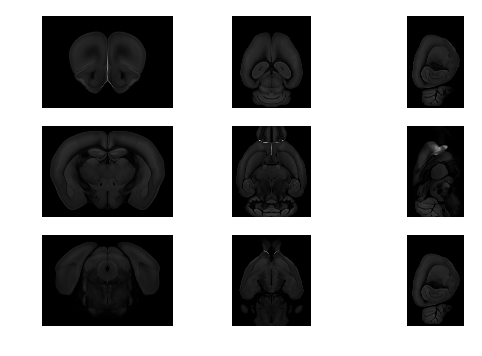

In [4]:
imgShow(refImg)

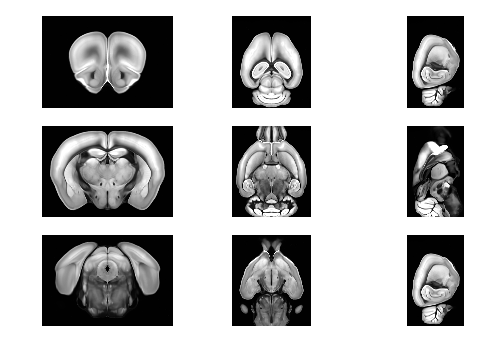

In [5]:
imgShow(refImg, vmax=500)

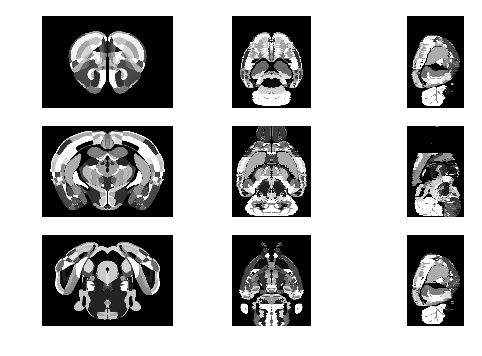

In [6]:
## Download annotations.
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

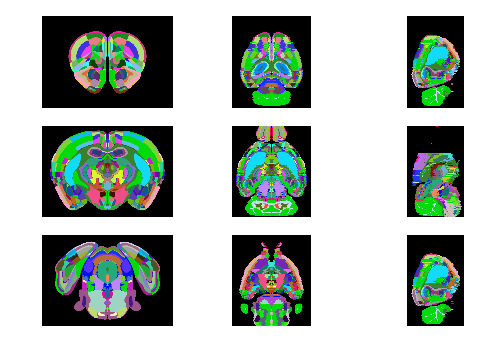

In [7]:
## Display annotations in random colors, set background color (label 0) to black
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

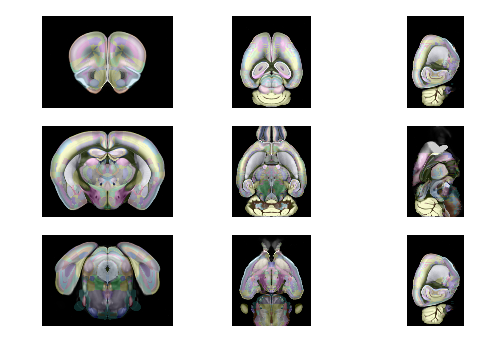

In [8]:
## Show annotations over original atlas data. To do this we must set newFig
## to False so that matplotlib appends the annotation data to the current figure
## instead of creating new one.
imgShow(refImg, vmax=500, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

In [8]:
## Write refAnnoImg to a .nii file.
imgWrite(refAnnoImg, './araccf2.nii')

In [63]:
print(refAnnoImg.GetSpacing())

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


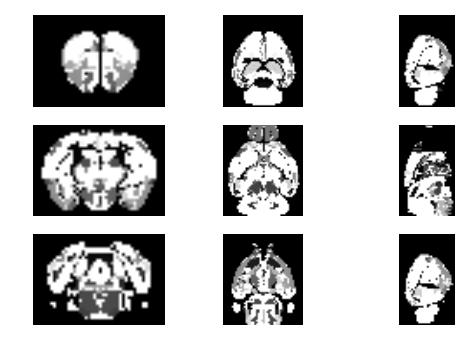

In [66]:
## Going to downsample, since 77 million points is way too many for our sake.
refAnnoImg_ds = imgResample(refAnnoImg, spacing=(0.25, 0.25, 0.25))
imgShow(refAnnoImg_ds, vmax=500)

In [67]:
imgWrite(refAnnoImg_ds, './araccf2_ds.nii')

In [68]:
import nibabel as nb

In [201]:
atlas = nb.load('araccf2_ds.nii')
data = atlas.get_data()
print data.shape

(46, 32, 53)


In [202]:
import numpy as np
output = np.asarray(data)
print output.shape

(46, 32, 53)


In [203]:
## Had trouble saving as fmt = '%i', fmt = '%d', so saved as string.
np.savetxt("araccf2_ds.csv", output, fmt='%s', delimiter=',')

In [226]:
## Convert 3D array memmap into XList, YList, ZList, BList for
## our CSV process.  Naive process -- didn't complete over 20 minutes.
output = np.empty(data.shape)
xList = [];
yList = [];
zList = [];
bList = [];

## For all x's...
for i in range(data.shape[0]):
    ## For all y's...
    for j in range(data.shape[1]):
        ## For all z's...
        for k in range(data.shape[2]):
                xList.append(i);
                yList.append(j);
                zList.append(k);
                bList.append(data[i][j][k]);

In [216]:
import csv
from itertools import izip 
with open('AraCCF2_ds_10x.csv', 'wb') as write:
    writer = csv.writer(write)
    writer.writerows(izip(xList, yList, zList, bList))

In [228]:
## Sanity check.  Are there elements in each?  Are there regions?
#print xList
#print yList
#print zList
#print bList

In [218]:
ccf_txt = 'natureCCFOhedited.csv'
ccf = {}
with open(ccf_txt, 'rU') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        # row[0] is ccf atlas index, row[4] is string of full name
        ccf[row[0]] = row[4];
        #print row[0]
        #print row[4]
        #print ', '.join(row)
ccf['0'] = 'invalid';
ccf['5'] = 'unknown1;';
ccf['13'] = 'unknown2;';
ccf['24'] = 'unknown3;';
ccf['32'] = 'unknown4;';
ccf['40'] = 'unknown5;';

In [219]:
# Sanity check: should match previous versions used (214 = red nucleus, 1 = ventral brain)
print ccf['214']
print ccf['1']

Red nucleus
Tuberomammillary nucleus, ventral part


In [220]:
# Sanity check: should all be same dimensions
# Should be equal to xdim * ydim * zdim
print len(xList)
print len(yList)
print len(zList)
print len(bList)

78016
78016
78016
78016


In [221]:
xColVector = np.asarray(xList)
yColVector = np.asarray(yList)
zColVector = np.asarray(zList)
bColVector = np.asarray(bList)

# Sanity check: should all be n x 1 vectors.
print xColVector.shape
print yColVector.shape
print zColVector.shape
print bColVector.shape

(78016,)
(78016,)
(78016,)
(78016,)


In [233]:
#print xColVector
#print yColVector
#print zColVector
#print bColVector

[ 0  0  0 ..., 45 45 45]
[ 0  0  0 ..., 31 31 31]
[ 0  1  2 ..., 50 51 52]
[0 0 0 ..., 0 0 0]


In [245]:
data_new = numpy.vstack([xColVector, yColVector, zColVector, bColVector])
print data_new.shape
data_convert = numpy.matrix.transpose(data_new)
print data_convert.shape

(4, 78016)
(78016, 4)


In [246]:
#data_new.shape
#data_convert = data_new.astype(numpy.int64)

In [247]:
# Find all unique regions of data_new
unique = [];

for l in data_convert:
    unique.append(l[3])

uniqueNP = np.asarray(unique)
allUnique = np.unique(uniqueNP)
numRegionsA = len(allUnique)

print allUnique
print numRegionsA  ## number of regions

[        0         1         2         7         8         9        10
        12        15        17        19        20        23        26
        27        28        30        33        35        36        41
        42        45        50        52        53        55        56
        59        60        61        64        66        67        68
        69        72        74        77        79        82        83
        84        87        90        91        92        96        97
        99       100       101       106       110       112       113
       114       118       120       121       122       123       126
       128       129       130       131       133       135       136
       137       139       143       146       147       148       149
       151       155       156       159       160       162       163
       167       169       170       171       173       175       177
       178       180       181       183       186       187       188
      

In [248]:
# Store and count the number of regions in each unique region
dictNumElementsRegion = {}

for i in range(numRegionsA):
    counter = 0;
    for l in data_convert:
        if l[3] == allUnique[i]:
            counter = counter + 1;
            dictNumElementsRegion[ccf[str(l[3])]] = counter;

In [249]:
region_names = dictNumElementsRegion.keys()
number_repetitions = dictNumElementsRegion.values()

In [250]:
from itertools import izip

with open('ARA_CCF2_ds_10XCounts.csv', 'wb') as write:
    writer = csv.writer(write)
    writer.writerows(izip(region_names, number_repetitions))

In [251]:
print refAnnoImg_ds.GetSpacing();

(0.25, 0.25, 0.25)


In [252]:
def generate_atlas_region_graph(data, path=None, numRegions = 71):
    font = {'weight' : 'bold',
        'size' : 18}

    matplotlib.rc('font', **font)

    region_dict = OrderedDict()

    for l in data:

        trace = ccf[str(l[3])]
        #trace = 'trace' + str(l[3])
        if trace not in region_dict:
            region_dict[trace] = np.array([[l[0], l[1], l[2], l[3]]])
            #print 'yay'
        else:
            tmp = np.array([[l[0], l[1], l[2], l[3]]])
            region_dict[trace] = np.concatenate((region_dict.get(trace, np.zeros((1,4))), tmp), axis=0)
            #print 'nay'

    current_palette = sns.color_palette("husl", numRegions)
    # print current_palette

    data = []
    for i, key in enumerate(region_dict):
        trace = region_dict[key]
        tmp_col = current_palette[i]
        tmp_col_lit = 'rgb' + str(tmp_col)
        temp = str(np.unique(trace[:,3])).replace("[", "")
        final = temp.replace("]", "")
    
        trace_scatter = Scatter3d(
            x = trace[:,0], 
            y = trace[:,1],
            z = trace[:,2],
            mode='markers',
            name=ccf[final],
            marker=dict(
                size=1.2,
                color=tmp_col_lit, #'purple',                # set color to an array/list of desired values
                colorscale='Viridis',   # choose a colorscale
                opacity=0.15
            )
        )

        data.append(trace_scatter)


    layout = Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        paper_bgcolor='rgb(0,0,0)',
        plot_bgcolor='rgb(0,0,0)'
    )

    fig = Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename= 'ARA_CCF_ds_10x' + "_region_color_spaced.html")

In [171]:
from plotly.offline import download_plotlyjs
from plotly.graph_objs import *
from plotly import tools
import plotly

import os

import gc  # garbage memory collection :)

import re
import matplotlib
import time
import seaborn as sns

from collections import OrderedDict

In [253]:
generate_atlas_region_graph(data_convert, path=None, numRegions = numRegionsA);